> # **Heart Failure Prediction**
>
>
> ### **Problem Statement**
> Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.
> 
> People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.
>
> ### **Aim**
> * 1.***To classify*** / predict whether a patient is prone to heart failure depending on multiple attributes.
> * 2.It is a ***binary classification*** with multiple numerical and categorical features.
>
>
>
> ### **Dataset Attributes**
> *     **Age** : age of the patient [years]
> *     **Sex** : sex of the patient [M: Male, F: Female]
> *     **ChestPainType** : chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
> *     **RestingBP** : resting blood pressure [mm Hg]
> *     **Cholesterol** : serum cholesterol [mm/dl]
> *     **FastingBS** : fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
> *     **RestingECG** : resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
> *     **MaxHR** : maximum heart rate achieved [Numeric value between 60 and 202]
> *     **ExerciseAngina** : exercise-induced angina [Y: Yes, N: No]
> *     **Oldpeak** : oldpeak = ST [Numeric value measured in depression]
> *     **ST_Slope** : the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
> *     **HeartDisease** : output class [1: heart disease, 0: Normal]


# 1. Imports dependencies

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import time

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [55]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler,RobustScaler, Normalizer,MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.layers import LeakyReLU
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [7]:
print(os.listdir('/kaggle/input/heart-failure-prediction'))

['heart.csv']


## 1.1 Reducing Memory of Data

In [8]:
def memory_usage_per_type(data_frame: pd.DataFrame)->None:
    types = ['float','int','object']
    for type in types:
        selected_col=data_frame.select_dtypes(include=[type])
        memory_usage_of_selected_type_b = selected_col.memory_usage(deep=True).sum()
        memory_usage_of_selected_type_mb=memory_usage_of_selected_type_b/1024**2
        print("memory usage for {} columns: {:03.4f} MB".format(type,memory_usage_of_selected_type_mb))

In [9]:
def reduce_memory_usage(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """
    Reduces the memory usage of a Pandas DataFrame by converting data types to appropriate
    numeric types or categoricals where possible.

    Args:
        df (pd.DataFrame): The input DataFrame.
        verbose (bool): If True, print detailed information about memory usage and conversion process.

    Returns:
        pd.DataFrame: The DataFrame with reduced memory usage.
    """
    
    start_time = time.time()
    
    # print(df.memory_usage(index = True))
    
    if verbose:
        start_mem = df.memory_usage(deep=True).sum() / 1024**2  # MB cinsinden başlangıç bellek kullanımı
        print(f"Başlangıç bellek kullanımı: {start_mem:.2f} MB")
        print("Başlangıç bellek kullanımı (türlere göre):")
        memory_usage_per_type(df)
        print("\n","-"*50,"\n")

    
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            
            c_min = df[col].min()
            c_max = df[col].max()
            
            try:
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        dtypes[col] = np.float64
                        
            except Exception as e:
                print(f"{col} için dönüşüm hatası: {e}")
        
        else:
            df[col] = df[col].astype('category')
            
    if verbose:
        end_mem = df.memory_usage(deep=True).sum() / 1024**2
        execution_time = time.time() - start_time
        print(f"Bitiş bellek kullanımı: {end_mem:.2f} MB")
        print(f"Bellek tasarrufu: {start_mem - end_mem:.2f} MB")
        print(f"Bellek azaltma oranı: {100 * (start_mem - end_mem) / start_mem:.1f}%")
        print(f"İşlem süresi: {execution_time:.2f} saniye")
        print("\n","-"*50,"\n")
        print("\nBitiş bellek kullanımı (türlere göre):")
        memory_usage_per_type(df)
    
    return df

# 2. Exploratory data analysis (EDA)

In [49]:
heart = pd.read_csv('/kaggle/input/heart-failure-prediction/heart.csv')

In [164]:
# heart = reduce_memory_usage(heart, verbose=True)

Başlangıç bellek kullanımı: 0.31 MB
Başlangıç bellek kullanımı (türlere göre):
memory usage for float columns: 0.0071 MB
memory usage for int columns: 0.0421 MB
memory usage for object columns: 0.2607 MB

 -------------------------------------------------- 

Bitiş bellek kullanımı: 0.02 MB
Bellek tasarrufu: 0.29 MB
Bellek azaltma oranı: 95.0%
İşlem süresi: 0.02 saniye

 -------------------------------------------------- 


Bitiş bellek kullanımı (türlere göre):
memory usage for float columns: 0.0001 MB
memory usage for int columns: 0.0001 MB
memory usage for object columns: 0.0001 MB


In [29]:
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [24]:
heart.tail()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


In [33]:
heart.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [30]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [31]:
heart.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [32]:
print(f"Training data size is {heart.shape}")

Training data size is (918, 12)


In [18]:
heart.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [19]:
heart.duplicated().sum()

0

In [25]:
heart.describe().style.background_gradient(cmap='Reds')

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [20]:
heart.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [36]:
heart.describe(include='O')

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [51]:
heart[heart['HeartDisease']==0].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Age,410.000000,50.551220,9.444915,28.000000,43.000000,51.000000,57.000000,76.000000
RestingBP,410.000000,130.180488,16.499585,80.000000,120.000000,130.000000,140.000000,190.000000
Cholesterol,410.000000,227.121951,74.634659,0.000000,197.250000,227.000000,266.750000,564.000000
FastingBS,410.000000,0.107317,0.309894,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,410.000000,148.151220,23.288067,69.000000,134.000000,150.000000,165.000000,202.000000
Oldpeak,410.000000,0.408049,0.699709,-1.100000,0.000000,0.000000,0.600000,4.200000
HeartDisease,410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [52]:
heart[heart['HeartDisease']==1].describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Age,508.000000,55.899606,8.727056,31.000000,51.000000,57.000000,62.000000,77.000000
RestingBP,508.000000,134.185039,19.828685,0.000000,120.000000,132.000000,145.000000,200.000000
Cholesterol,508.000000,175.940945,126.391398,0.000000,0.000000,217.000000,267.000000,603.000000
FastingBS,508.000000,0.334646,0.472332,0.000000,0.000000,0.000000,1.000000,1.000000
MaxHR,508.000000,127.655512,23.386923,60.000000,112.000000,126.000000,144.250000,195.000000
Oldpeak,508.000000,1.274213,1.151872,-2.600000,0.000000,1.200000,2.000000,6.200000
HeartDisease,508.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')
heart.describe().style.apply(highlight_min, props='color:Black;background-color:Pink', axis=0)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [37]:
heart.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [ ]:
string_col = heart.select_dtypes(include="object").columns
heart[string_col] = heart[string_col].astype("string")

In [21]:
# Get numeric columns
numeric_columns = heart.select_dtypes(include=['number']).columns.tolist()
print("Numeric Columns:", numeric_columns)

print("\n","-"*100,"\n")
# Get categorical columns
categorical_columns = heart.select_dtypes(include=['object','string']).columns.tolist()
print("Categorical Columns:", categorical_columns)

Numeric Columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']

 ---------------------------------------------------------------------------------------------------- 

Categorical Columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [22]:
heart[categorical_columns].head()
print(f"The distribution of categorical values")
print("-"*50)
for col in categorical_columns:
    print(heart[col].value_counts())
    print("-"*50)

The distribution of categorical values
--------------------------------------------------
Sex
M    725
F    193
Name: count, dtype: Int64
--------------------------------------------------
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: Int64
--------------------------------------------------
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: Int64
--------------------------------------------------
ExerciseAngina
N    547
Y    371
Name: count, dtype: Int64
--------------------------------------------------
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: Int64
--------------------------------------------------


## 2.2 VIZ 

Number of people having heart disease:  508
Number of people does not have heart disease :  410


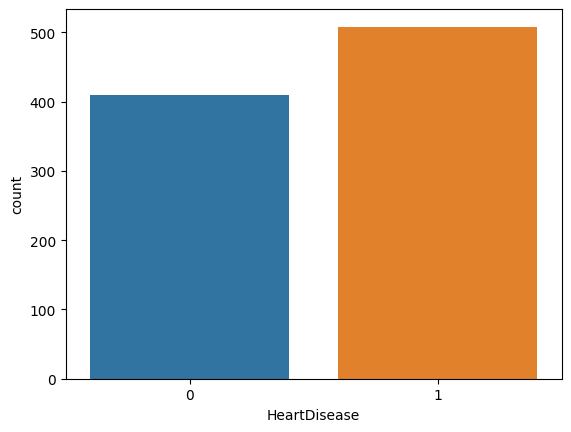

In [23]:
ax = sns.countplot(x = heart['HeartDisease'],label="Count")      
B, M = heart['HeartDisease'].value_counts()
print('Number of people having heart disease: ',B)
print('Number of people does not have heart disease : ',M)

<Axes: ylabel='count'>

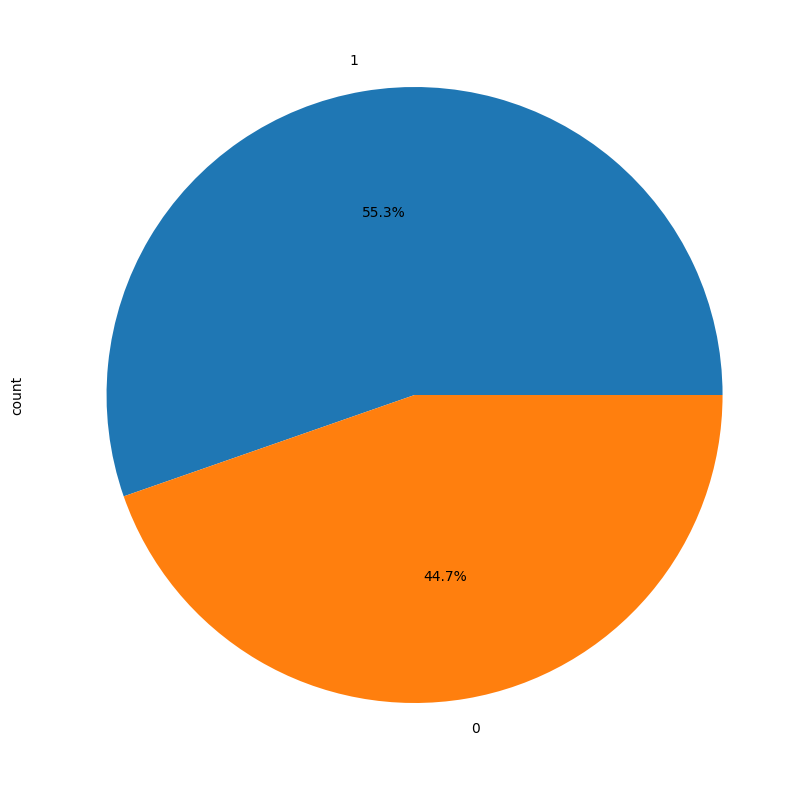

In [82]:
heart["HeartDisease"].value_counts().plot(kind="pie", autopct='%1.1f%%', figsize=(10,10))

In [81]:
heart.groupby(['Sex','HeartDisease'])['HeartDisease'].count()

Sex  HeartDisease
F    0               143
     1                50
M    0               267
     1               458
Name: HeartDisease, dtype: int64

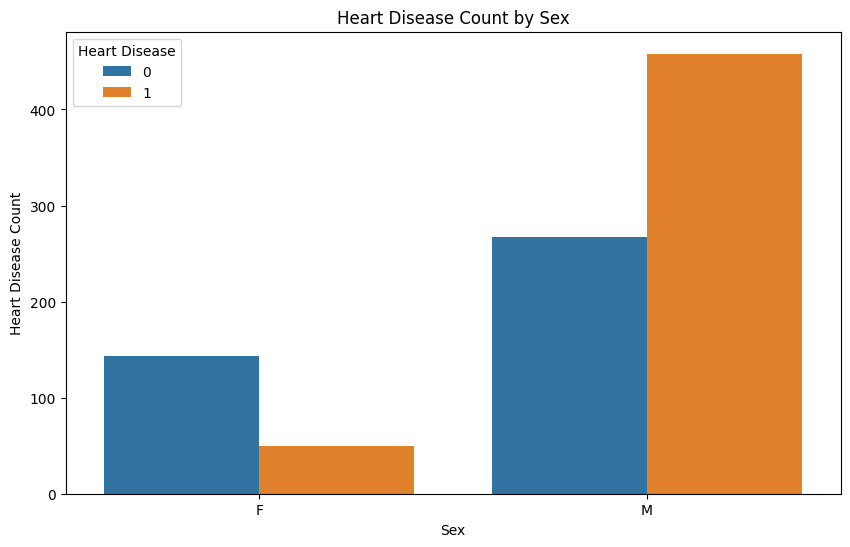

In [40]:
grouped_data = heart.groupby(['Sex', 'HeartDisease'])['HeartDisease'].count().reset_index(name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='Sex', y='Count', hue='HeartDisease')
plt.title('Heart Disease Count by Sex')
plt.xlabel('Sex')
plt.ylabel('Heart Disease Count')
plt.legend(title='Heart Disease')
plt.show()

In [21]:
outliers_info = {}
outlier_cleaned_heart = heart.copy()  # Create a copy of the original DataFrame

for column in heart.select_dtypes(include=['float64', 'int64','int16','int8','float16']).columns:
    Q1 = heart[column].quantile(0.25)
    Q3 = heart[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count the number of outliers
    outlier_count = heart[(heart[column] < lower_bound) | (heart[column] > upper_bound)].shape[0]
    outliers_info[column] = outlier_count

    # Remove outliers by filtering the DataFrame directly
    outlier_cleaned_heart = outlier_cleaned_heart[
        (outlier_cleaned_heart[column] >= lower_bound) & (outlier_cleaned_heart[column] <= upper_bound)
    ]

# Display outlier information
for i, j in outliers_info.items():
    if j > 0:
        print(f'{i} has : {j} outliers')

RestingBP has : 28 outliers
Cholesterol has : 183 outliers
FastingBS has : 214 outliers
MaxHR has : 2 outliers
Oldpeak has : 16 outliers


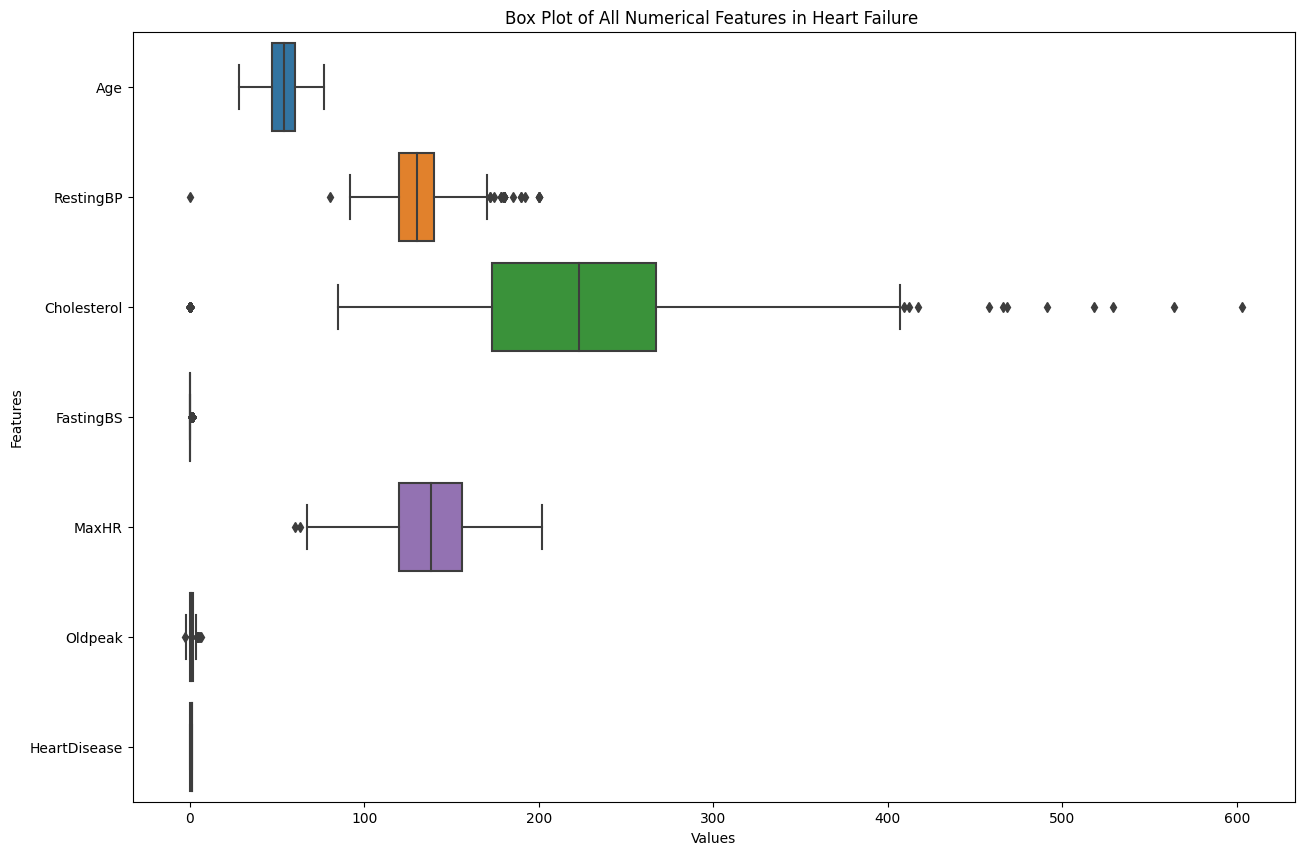

In [22]:
# Create a box plot for all numerical columns
plt.figure(figsize=(15, 10))  # Set figure size
sns.boxplot(data=heart, orient="h")  # Horizontal box plot
plt.title('Box Plot of All Numerical Features in Heart Failure ')
plt.xlabel('Values')
plt.ylabel('Features')
plt.show()

In [23]:
# Display the shape of the original and cleaned DataFrames
print(f"Original DataFrame shape: {heart.shape}")
print(f"Cleaned DataFrame shape: {outlier_cleaned_heart.shape}")

Original DataFrame shape: (918, 12)
Cleaned DataFrame shape: (588, 12)


['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
Malignant cases: 508
Benign cases: 410


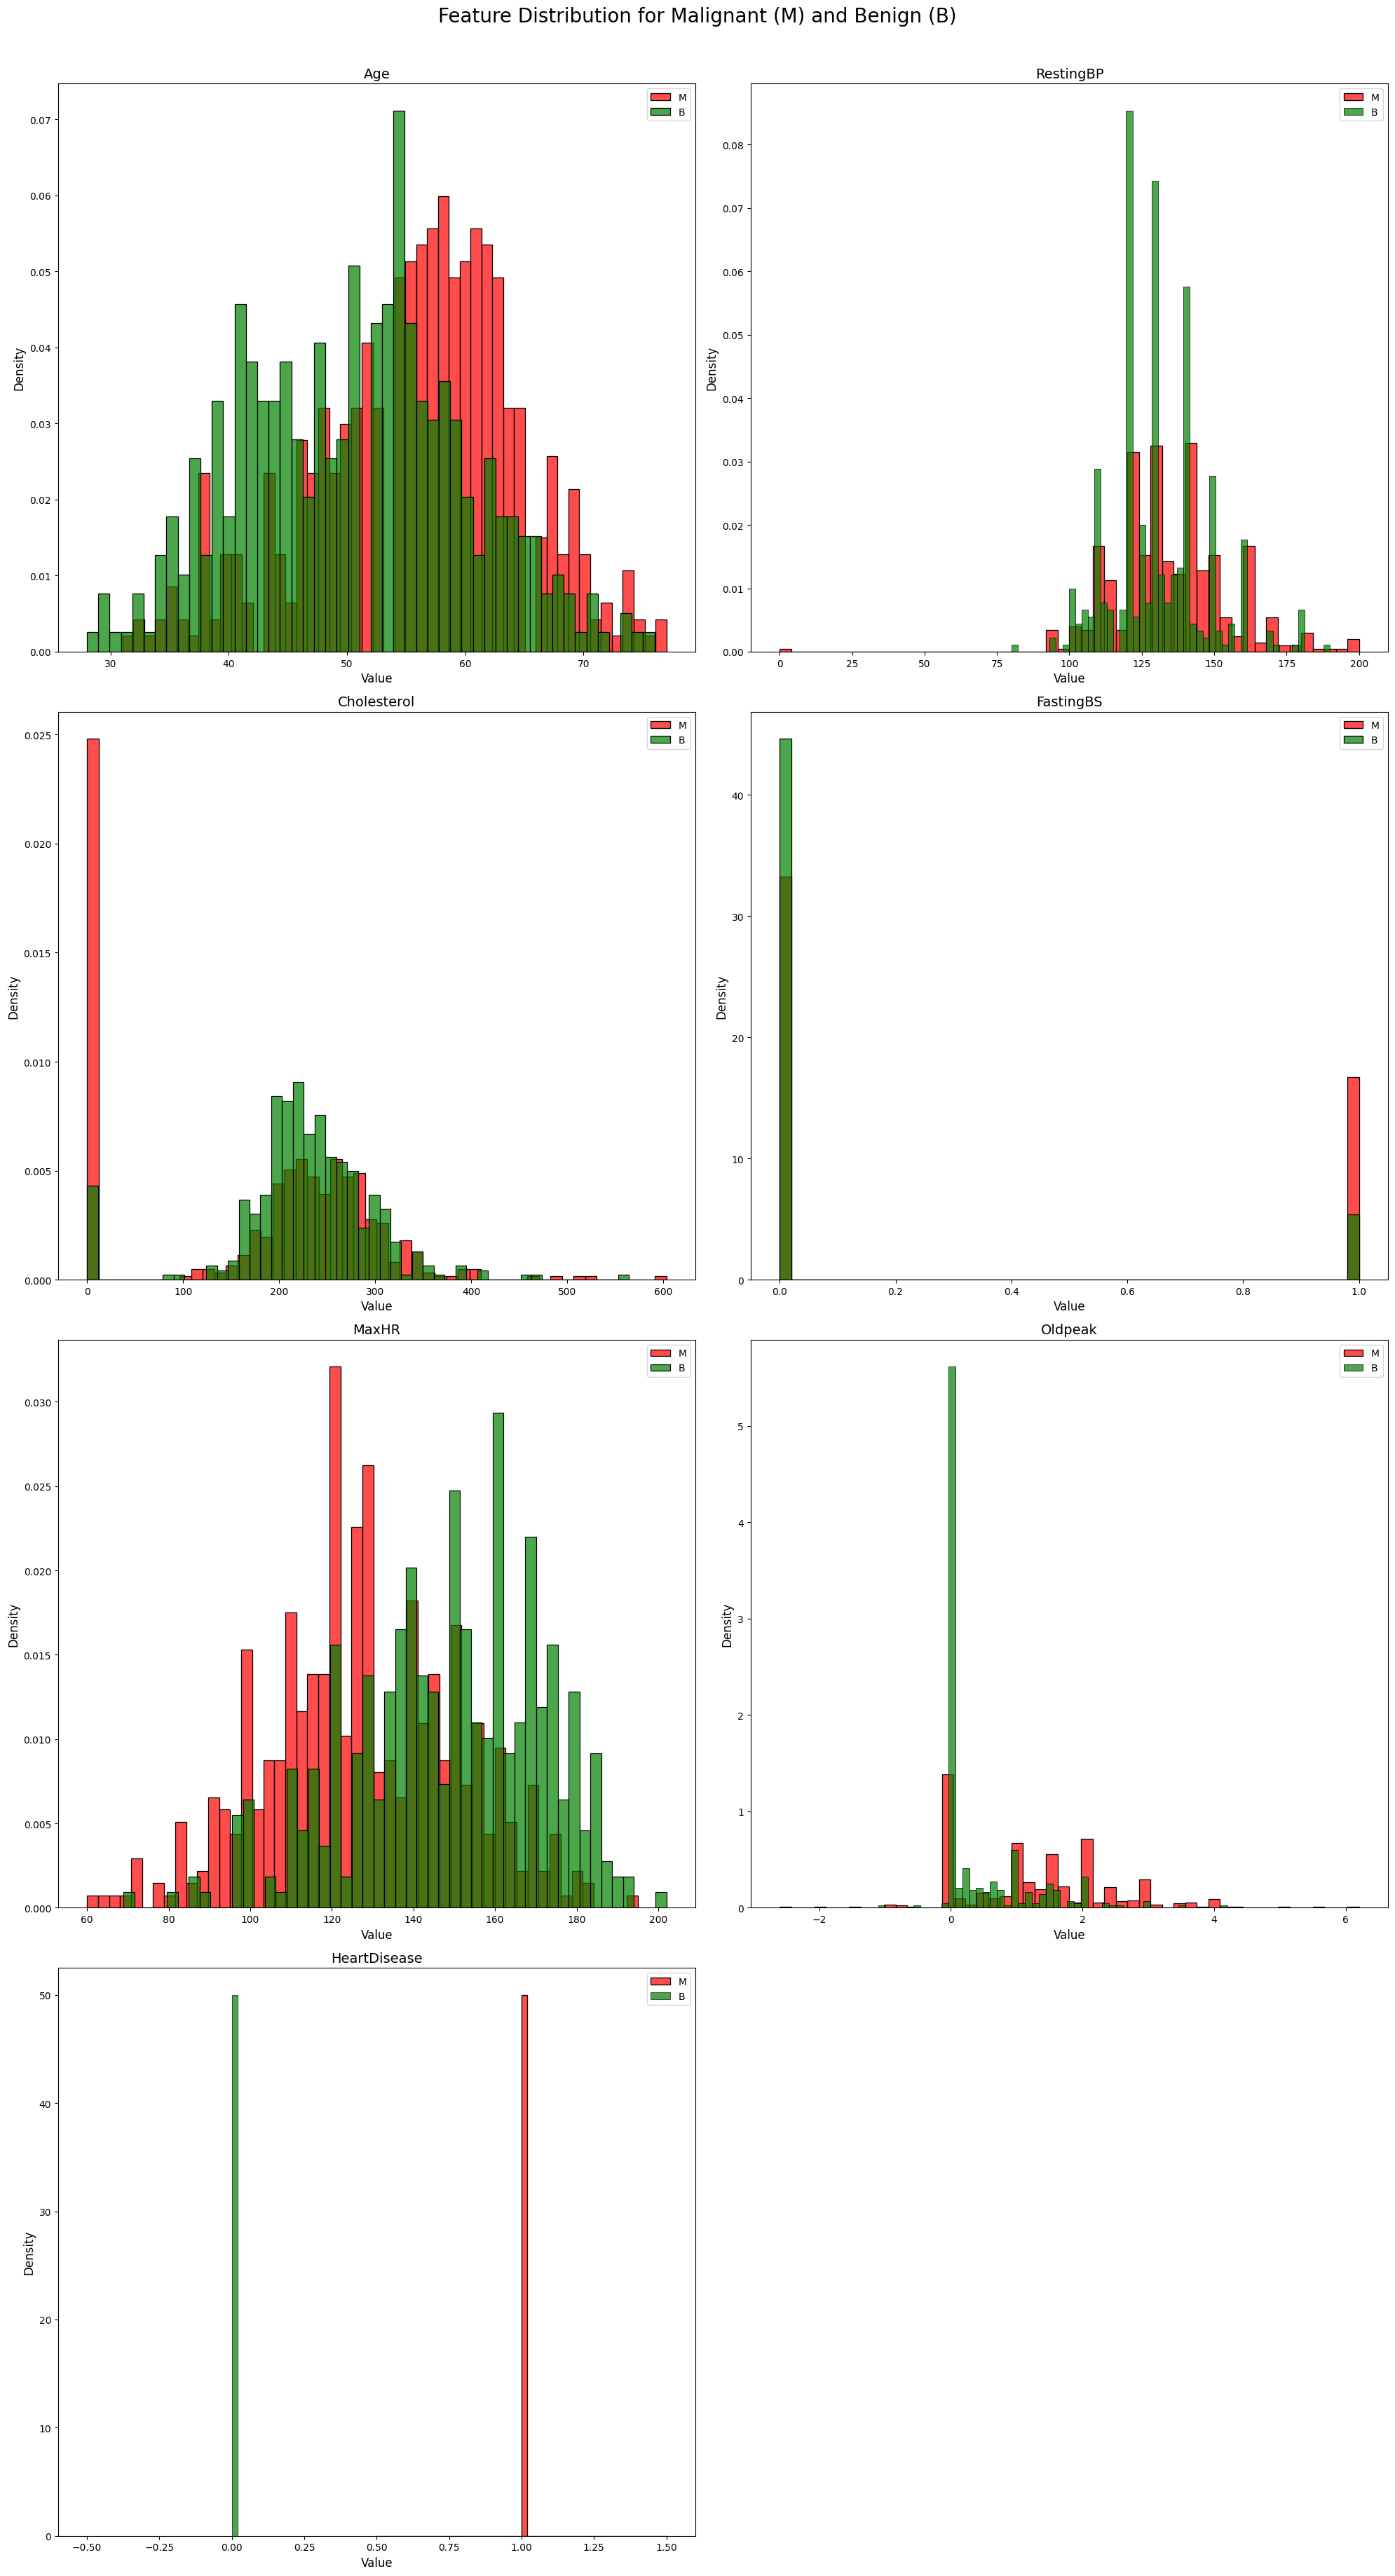

In [24]:
features_mean = numeric_columns
print(features_mean)

dfM = heart[heart['HeartDisease'] == 1]  # not have it
dfB = heart[heart['HeartDisease'] == 0]  # have it

print(f"Malignant cases: {dfM.shape[0]}")
print(f"Benign cases: {dfB.shape[0]}")

# Stack the data
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 36))  # 6 rows, 5 columns for 30 features
axes = axes.ravel()

for idx, ax in enumerate(axes):
    if idx < len(features_mean):  # Check if feature exists
        ax.clear()  # Clear previous plots
        binwidth = (max(heart[features_mean[idx]]) - min(heart[features_mean[idx]])) / 50
        
        # Draw histograms using Seaborn
        sns.histplot(data=dfM, x=features_mean[idx], bins=int((max(heart[features_mean[idx]]) - min(heart[features_mean[idx]])) / binwidth), 
                     color='red', label='M', alpha=0.7, stat='density', kde=False, ax=ax)
        
        sns.histplot(data=dfB, x=features_mean[idx], bins=int((max(heart[features_mean[idx]]) - min(heart[features_mean[idx]])) / binwidth), 
                     color='green', label='B', alpha=0.7, stat='density', kde=False, ax=ax)

        # Title and labels
        ax.set_title(features_mean[idx], fontsize=14)
        ax.set_xlabel('Value', fontsize=12)
        ax.set_ylabel('Density', fontsize=12)

        # Legend
        ax.legend(loc='upper right')
    else:
        ax.axis('off')  # Hide unused subplots

plt.tight_layout()
plt.suptitle('Feature Distribution for Malignant (M) and Benign (B)', fontsize=20, y=1.02)
plt.show()

[]

<Figure size 1500x1000 with 0 Axes>

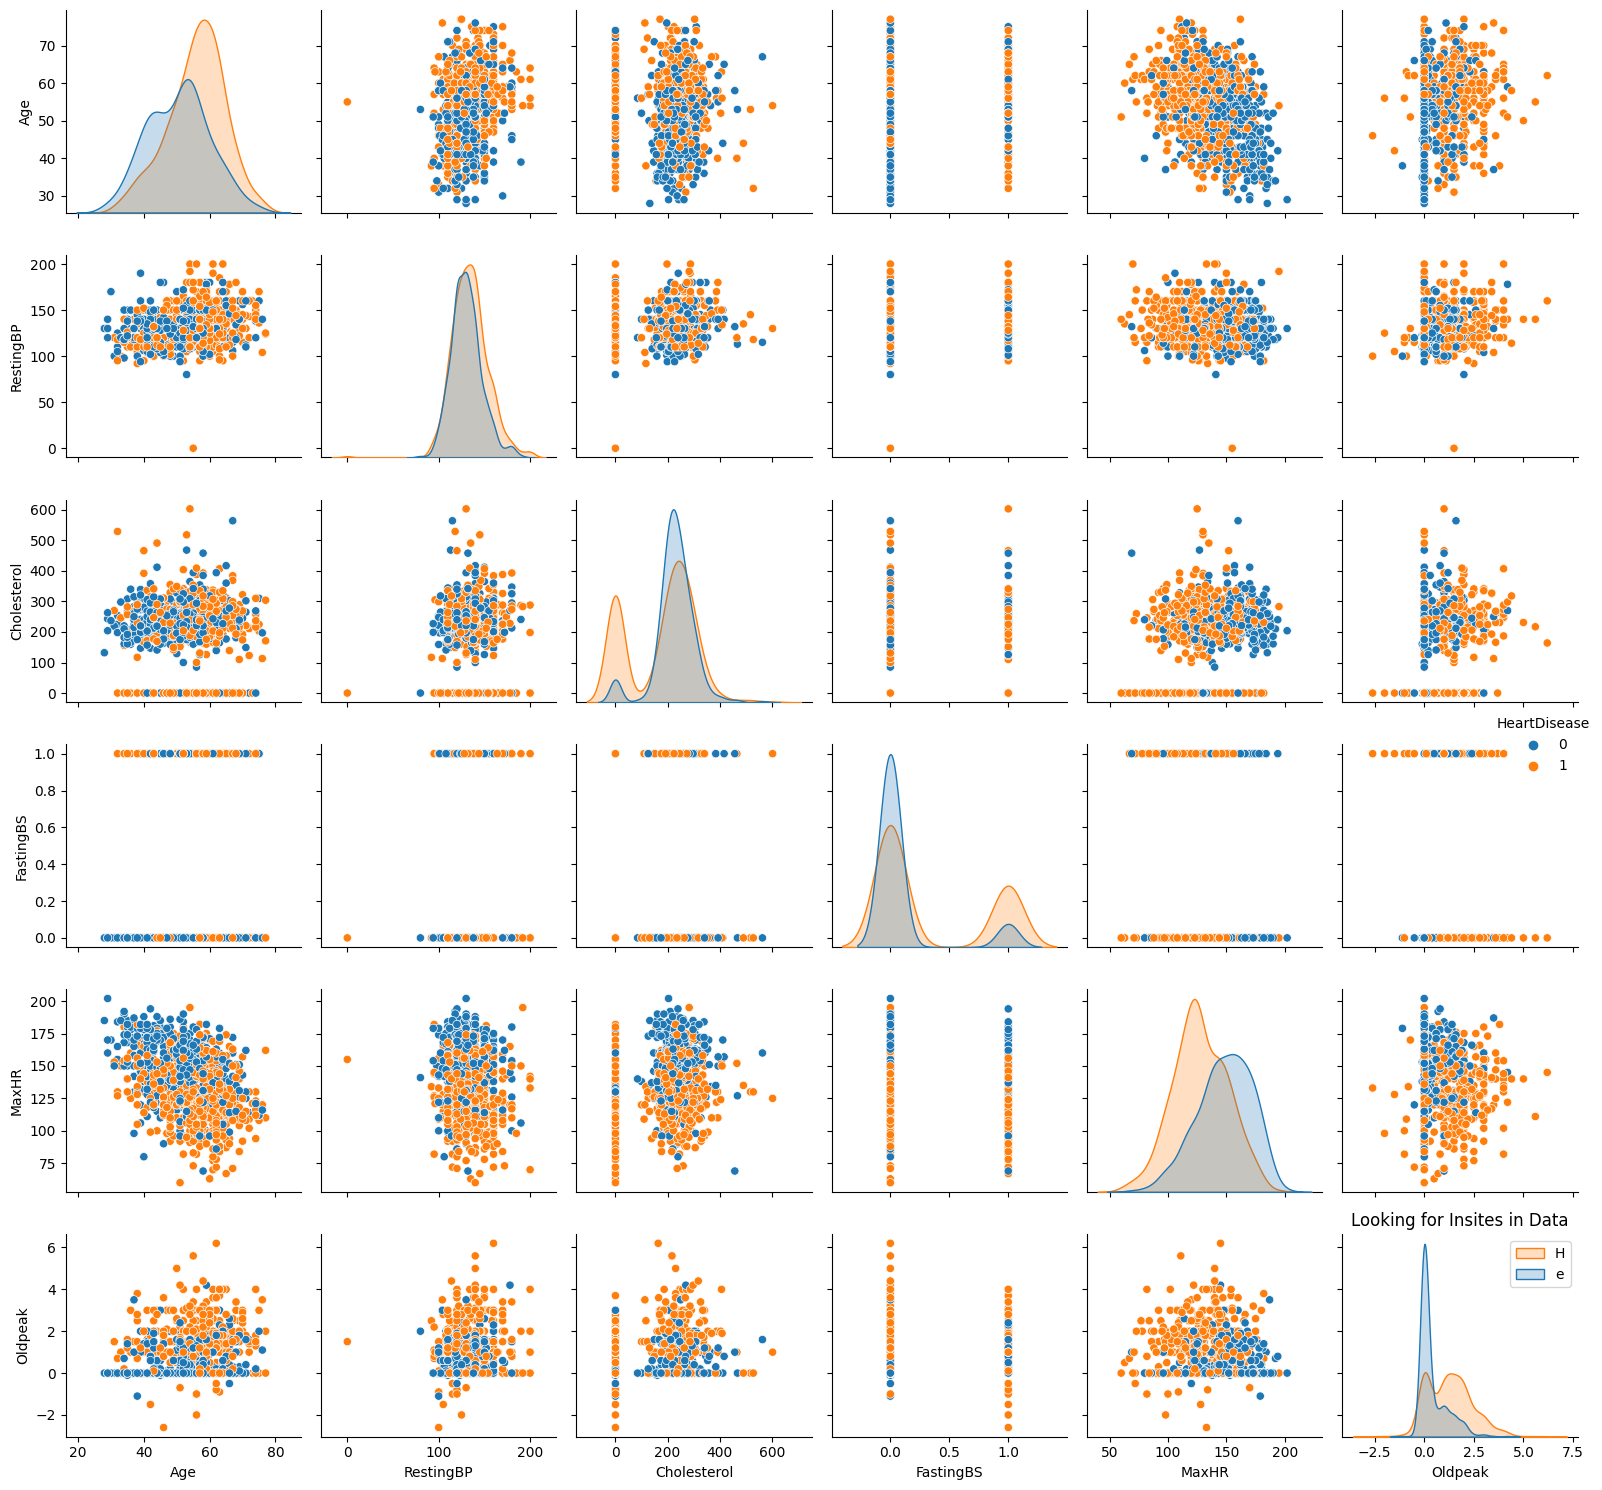

In [25]:
plt.figure(figsize=(15,10))
sns.pairplot(heart,hue="HeartDisease")
plt.title("Looking for Insites in Data")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

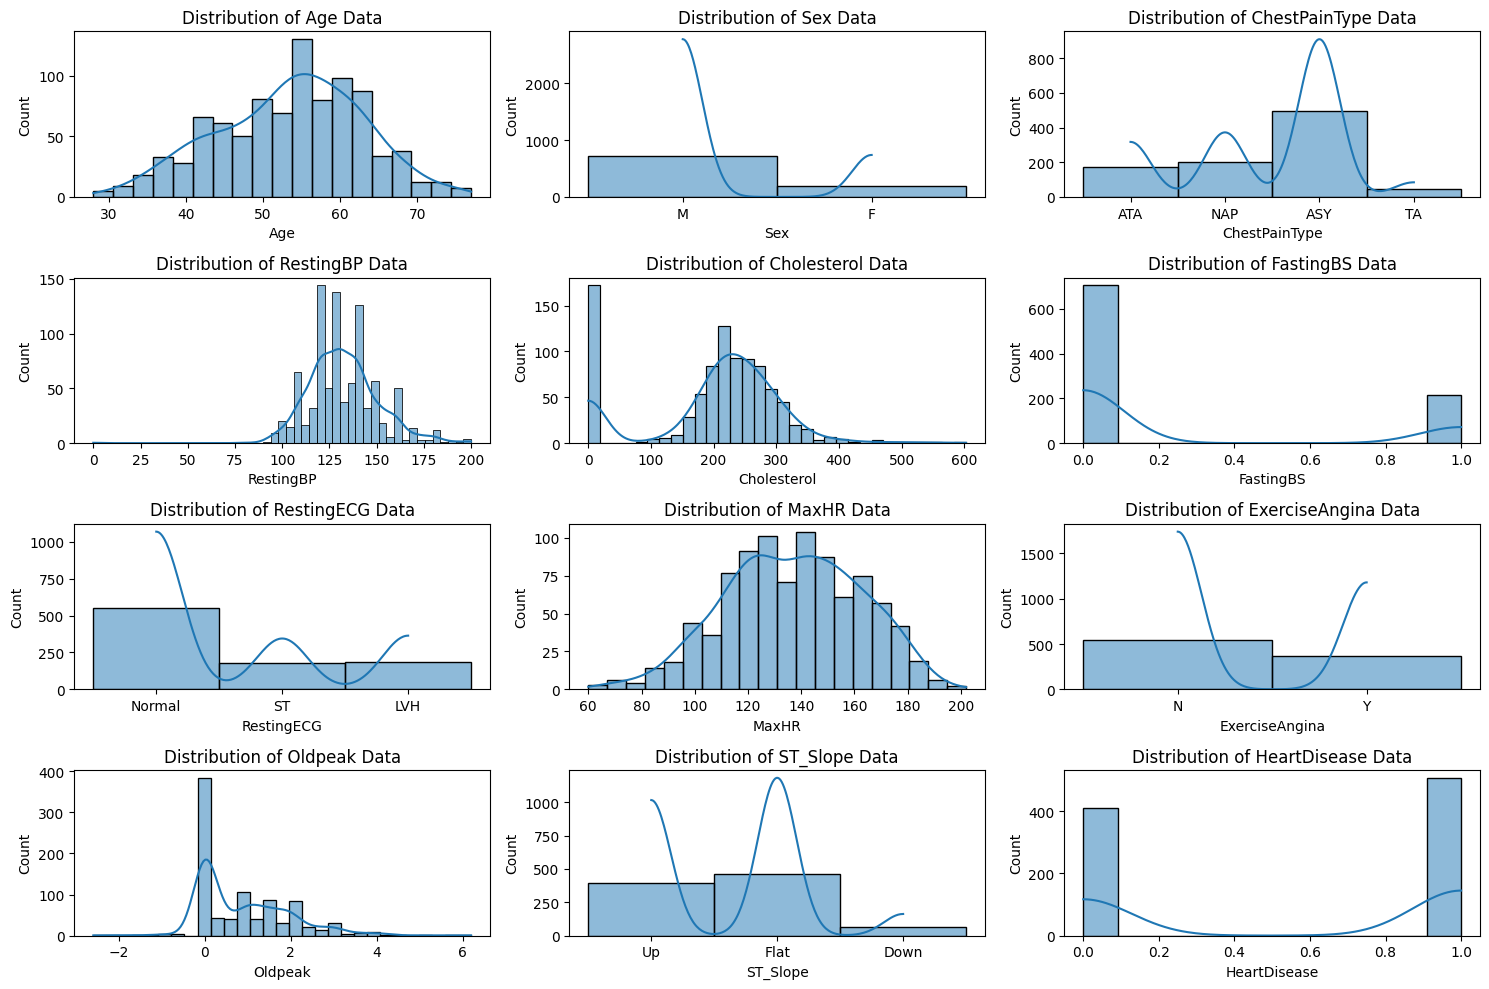

In [26]:
plt.figure(figsize=(15,10))
for i,col in enumerate(heart.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(heart[col],kde=True)
    plt.tight_layout()
    plt.plot()

In [45]:
heart["age_cat"]=pd.cut(heart["Age"],4)
heart[["age_cat","HeartDisease"]].groupby("age_cat",as_index=False).mean().sort_values(by="HeartDisease",ascending=False).style.background_gradient(cmap='Reds')

,age_cat,HeartDisease
3,"(64.75, 77.0]",0.699029
2,"(52.5, 64.75]",0.647196
1,"(40.25, 52.5]",0.431973
0,"(27.951, 40.25]",0.344086


# 3 FEATURE SELECTION

## Encoding
Label Encoding (For Tree based Machine Learning Algorithms) and One-Hot Encoding (for not for Tree's)

### Label Encoding

In [56]:
from sklearn.preprocessing import LabelEncoder
df_tree  = heart.apply(LabelEncoder().fit_transform)
df_tree.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,12,1,1,41,147,0,1,98,0,10,2,0
1,21,0,2,55,40,0,1,82,0,20,1,1
2,9,1,1,31,141,0,2,25,0,10,2,0
3,20,0,0,39,72,0,1,34,1,25,1,1
4,26,1,2,49,53,0,1,48,0,10,2,0


### One-Hot Encoding

In [33]:
string_col = heart.select_dtypes(include="object").columns
heart[string_col] = heart[string_col].astype("string")

In [34]:
string_col = heart.select_dtypes("string").columns.to_list()
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [35]:
## Creaeting one hot encoded features for working with non tree based algorithms 
df_nontree = pd.get_dummies(heart,columns=categorical_columns,drop_first=False)
df_nontree.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True


## splitting the dataset

In [57]:
target = 'HeartDisease'

In [60]:
# Prepare the data for training
X = df_tree.drop([target], axis=1)
y = df_tree[target]

In [61]:
from sklearn.preprocessing import RobustScaler

# Ölçekleyici
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [65]:
from sklearn.model_selection import train_test_split

# Train-test split (0.15 oranında)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

# Sonuçları kontrol etme
print("X_train şekli:", X_train.shape)
print("y_train şekli:", y_train.shape)
print("X_test şekli:", X_test.shape)
print("y_test şekli:", y_test.shape)

X_train şekli: (734, 11)
y_train şekli: (734,)
X_test şekli: (184, 11)
y_test şekli: (184,)


# ML Models

## Tree based algos 
#### using label encoder for it 

In [31]:
feature_col_tree = df_tree.columns.to_list()
feature_col_tree.remove(target)
feature_col_tree

['Age',
 'Sex',
 'ChestPainType',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'RestingECG',
 'MaxHR',
 'ExerciseAngina',
 'Oldpeak',
 'ST_Slope']

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler

acc_dt_grid = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'min_samples_split': [2, 6, 10],
    'min_samples_leaf': [1, 4, 5],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 4, 6, 8]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, 
                           scoring='accuracy', cv=kf, n_jobs=-1, verbose=0)

# Ölçekleyici
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

grid_search.fit(X_scaled, y)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy Score: {grid_search.best_score_:.4f}")

clf = grid_search.best_estimator_

for fold, (train_index, val_index) in enumerate(kf.split(X=X_scaled, y=y)):

    X_train, y_train = df_tree.iloc[train_index][feature_col_tree], y[train_index]
    X_valid, y_valid = df_tree.iloc[val_index][feature_col_tree], y[val_index]

    clf.fit(X_train, y_train)

    predictions = clf.predict(X_valid)

    accuracy = accuracy_score(y_valid, predictions)
    acc_dt_grid.append(accuracy)
    print(f"Fold {fold + 1} - Doğruluk oranı: {accuracy:.4f}")

    report = classification_report(y_valid, predictions)
    print(f"Fold {fold + 1} - Sınıflandırma raporu:\n {report}")

print(f"\nAverage Accuracy Score: {sum(acc_dt_grid) / len(acc_dt_grid):.4f}")

Best Parameters: {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Accuracy Score: 0.8464
Fold 1 - Doğruluk oranı: 0.9022
Fold 1 - Sınıflandırma raporu:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89        82
           1       0.92      0.90      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184

Fold 2 - Doğruluk oranı: 0.8043
Fold 2 - Sınıflandırma raporu:
               precision    recall  f1-score   support

           0       0.74      0.85      0.80        82
           1       0.87      0.76      0.81       102

    accuracy                           0.80       184
   macro avg       0.81      0.81      0.80       184
weighted avg       0.81      0.80      0.80       184

Fold 3 - Doğruluk oranı: 0.7609
Fold 3 - Sınıflandırma raporu:
               precisi

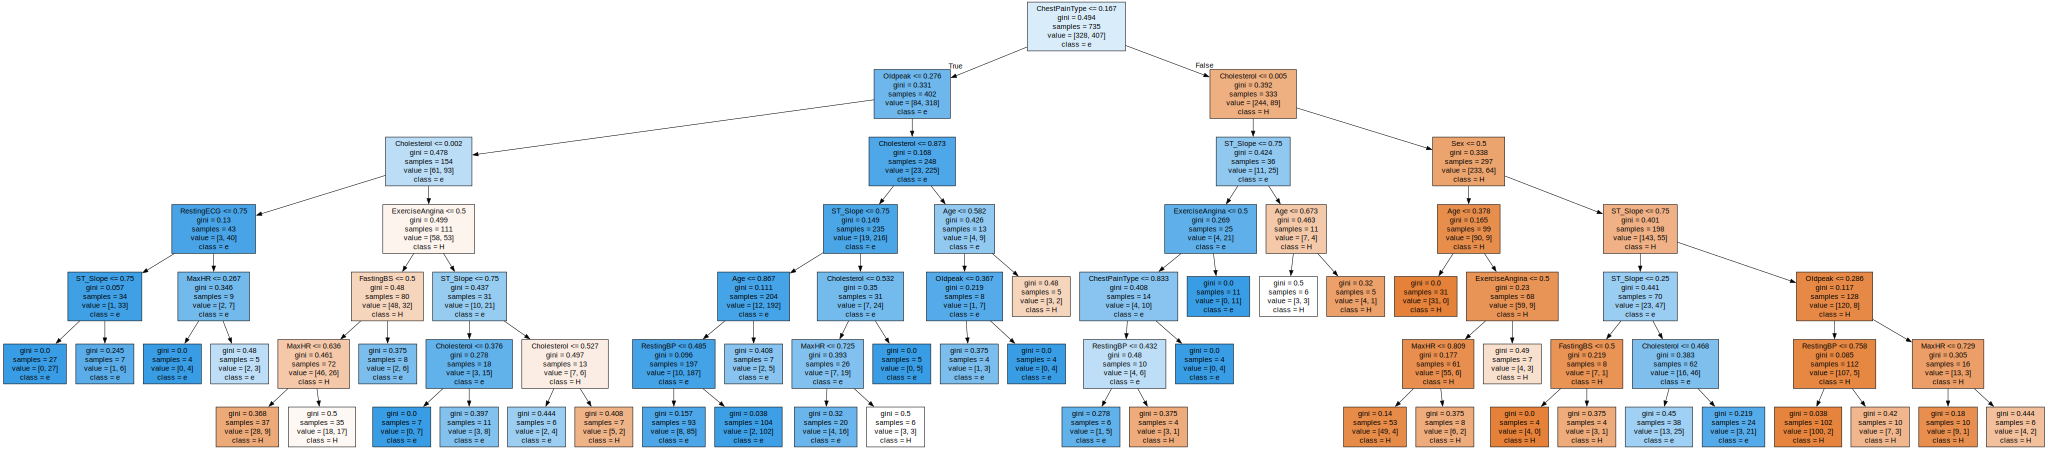

In [101]:
import graphviz
from sklearn import tree
# DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=feature_col_tree,  
                                class_names=target,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# Boş liste oluşturma (doğruluk skorlarını tutmak için)
acc_RandF = []

# Stratified K-Fold tanımlama (5 katlı)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest için parametre aralığı belirleme
param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV nesnesini oluşturma
grid_search = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, scoring='roc_auc', cv=kf, n_jobs=-1, verbose=2)

# Ölçekleyici
scaler = MinMaxScaler()

# Veriyi ölçeklendirme
X_scaled = scaler.fit_transform(df_tree[feature_col_tree])

# GridSearchCV ile modeli eğitme
grid_search.fit(X_scaled, y)

# En iyi parametreleri ve en iyi ROC AUC skorunu göster
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best ROC AUC Score: {grid_search.best_score_:.4f}")

# En iyi model ile tahmin yapma
best_model = grid_search.best_estimator_

# Her bir fold için stratified k-fold ile doğrulama
for fold, (train_index, val_index) in enumerate(kf.split(X=df_tree, y=y)):

    # Eğitim ve doğrulama setlerini tanımla
    X_train, y_train = df_tree.iloc[train_index][feature_col_tree], y[train_index]
    X_valid, y_valid = df_tree.iloc[val_index][feature_col_tree], y[val_index]

    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)

    # En iyi model ile eğitme
    best_model.fit(X_train, y_train)

    # Tahmin yapma
    y_pred = best_model.predict(X_valid)

    # ROC AUC skoru hesapla
    acc = roc_auc_score(y_valid, y_pred)
    acc_RandF.append(acc)

    # Sonuçları göster
    print(f"Fold {fold + 1}:")
    print(classification_report(y_valid, y_pred))
    print(f"ROC AUC Score for Fold {fold + 1}: {acc:.4f}")
    print("-" * 50)

# Tüm fold (katlama) sonuçlarını göster
print(f"\nAverage ROC AUC Score: {sum(acc_RandF) / len(acc_RandF):.4f}")


Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tota

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# Eğitim ve test verilerini ayırma
X_train, X_test, y_train, y_test = train_test_split(df_tree[feature_col_tree], y, test_size=0.2, random_state=42)

# MinMaxScaler ile veriyi ölçeklendir
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelin hiperparametreleri
model_params = {
    'criterion': 'entropy',
    'max_depth': 5,
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'n_estimators': 100,
    'random_state': 1
}

# Modeli oluşturma
rf_clf = RandomForestClassifier(**model_params)

# Modeli eğitme
rf_clf.fit(X_train, y_train)

# Tahmin yapma
predictions = rf_clf.predict(X_test)

# ROC AUC skoru hesapla
roc_auc = roc_auc_score(y_test, predictions)

# Sınıflandırma raporu
report = classification_report(y_test, predictions)

# Sonuçları yazdırma
print("Doğruluk oranı (ROC AUC):", roc_auc)
print("Sınıflandırma raporu:\n", report)


Doğruluk oranı (ROC AUC): 0.890156572399563
Sınıflandırma raporu:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87        77
           1       0.91      0.90      0.91       107

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



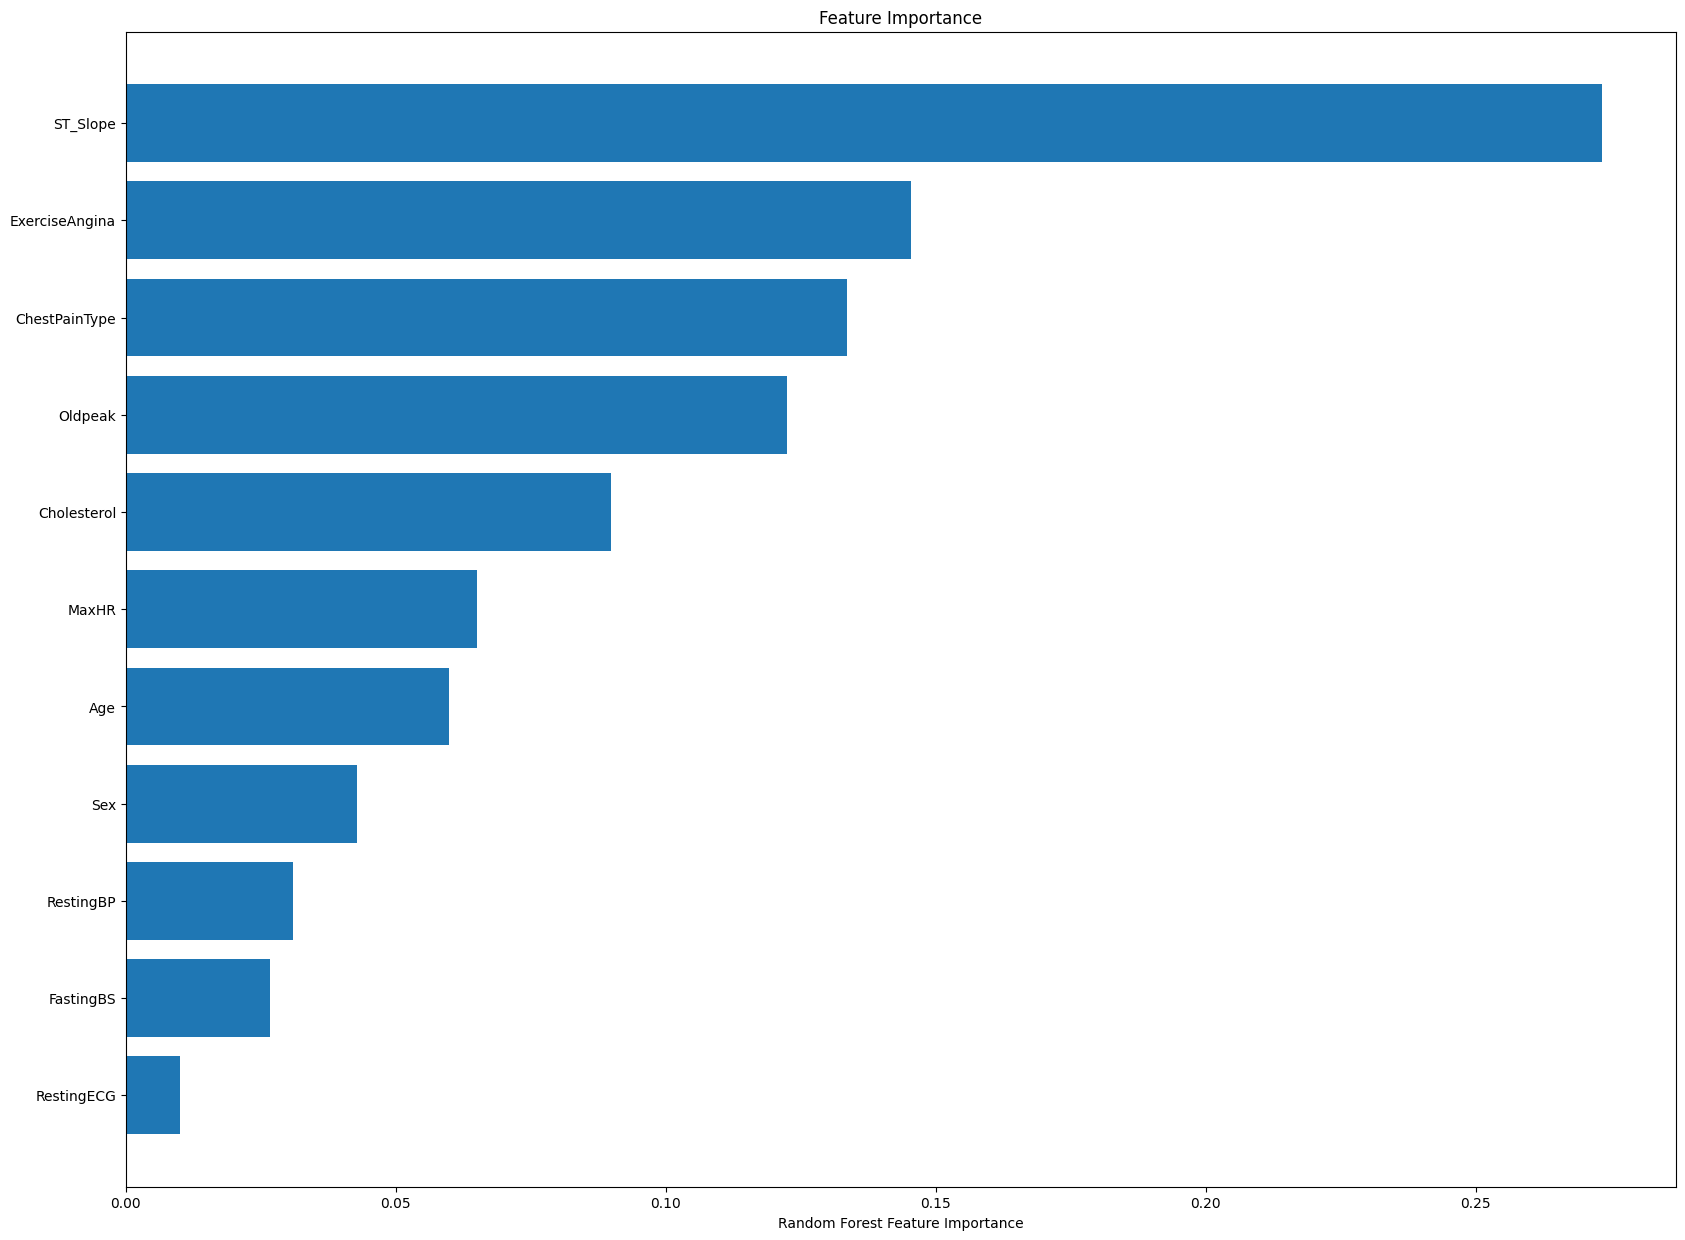

In [110]:
plt.figure(figsize=(20,15))
importance = rf_clf.feature_importances_
idxs = np.argsort(importance)
plt.title("Feature Importance")
plt.barh(range(len(idxs)),importance[idxs],align="center")
plt.yticks(range(len(idxs)),[feature_col_tree[i] for i in idxs])
plt.xlabel("Random Forest Feature Importance")
#plt.tight_layout()
plt.show()

In [111]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

# Eğitim ve test verilerini ayırma
X_train, X_test, y_train, y_test = train_test_split(df_tree[feature_col_tree], y, test_size=0.2, random_state=42)

# MinMaxScaler ile veriyi ölçeklendir
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# XGBClassifier için parametreler
param_grid = {
    'n_estimators': [100, 200],  # Ağaç sayısı
    'max_depth': [3, 5, 7],       # Ağaç derinliği
    'learning_rate': [0.01, 0.1],  # Öğrenme oranı
    'subsample': [0.8, 1.0],      # Alt örnekleme oranı
    'colsample_bytree': [0.8, 1.0]  # Ağaç için alt sütun örnekleme
}

# GridSearchCV ile en iyi parametreleri bulma
grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                           param_grid=param_grid, 
                           scoring='roc_auc', 
                           cv=3, 
                           verbose=1,
                           n_jobs=-1)

# Grid search'ü eğitim verileri üzerinde uygula
grid_search.fit(X_train, y_train)

# En iyi parametreleri ve skoru yazdır
print("En iyi parametreler:", grid_search.best_params_)
print("En iyi ROC AUC skoru:", grid_search.best_score_)

# En iyi model ile tahmin yapma
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# ROC AUC skoru hesapla ve sınıflandırma raporunu al
roc_auc = roc_auc_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Sonuçları yazdırma
print("Test seti için ROC AUC skoru:", roc_auc)
print("Sınıflandırma raporu:\n", report)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
En iyi parametreler: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
En iyi ROC AUC skoru: 0.9297120878032111
Test seti için ROC AUC skoru: 0.8771695594125501
Sınıflandırma raporu:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86        77
           1       0.90      0.90      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



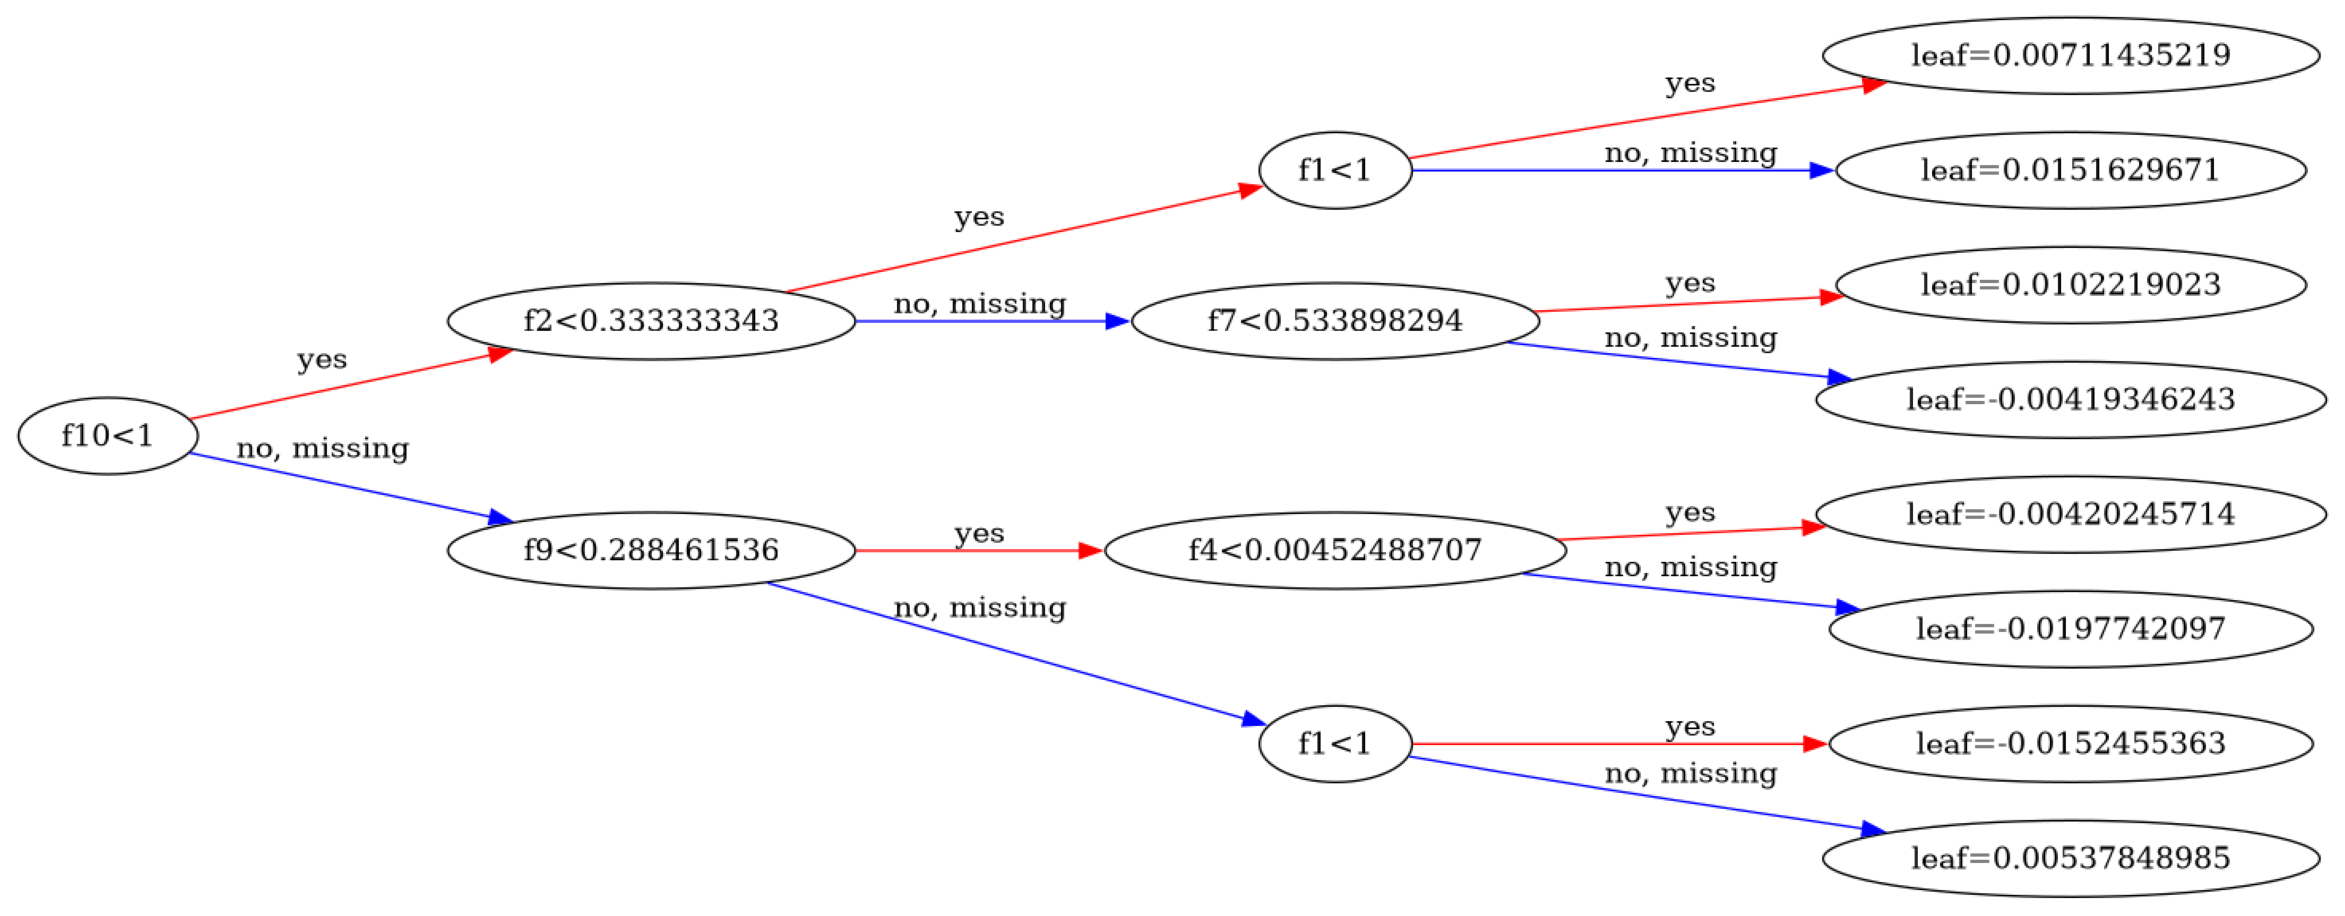

In [113]:
fig, ax = plt.subplots(figsize=(30, 30))
from xgboost import plot_tree
plot_tree(best_model,num_trees=0,rankdir="LR",ax=ax)
plt.show()

## None Tree Based Algos
#### We are going to use one-hot encoding

In [36]:
# Convert all boolean columns to 1 (True) and 0 (False)
df_nontree = df_nontree.astype({col: int for col in df_nontree.select_dtypes(include=['bool']).columns})

# Define the target column
target = "HeartDisease"

# Separate the target variable
y = df_nontree[target].values

# Drop the target column from the DataFrame
df_nontree.drop(target, axis=1, inplace=True)

# Concatenate the target column back at the end
df_nontree = pd.concat([df_nontree, pd.Series(y, name=target)], axis=1)

In [37]:
# Display the first few rows of the modified DataFrame
df_nontree.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,HeartDisease
0,40,140,289,0,172,0.0,0,1,0,1,...,0,0,1,0,1,0,0,0,1,0
1,49,160,180,0,156,1.0,1,0,0,0,...,0,0,1,0,1,0,0,1,0,1
2,37,130,283,0,98,0.0,0,1,0,1,...,0,0,0,1,1,0,0,0,1,0
3,48,138,214,0,108,1.5,1,0,1,0,...,0,0,1,0,0,1,0,1,0,1
4,54,150,195,0,122,0.0,0,1,0,0,...,0,0,1,0,1,0,0,0,1,0


In [38]:
feature_col_nontree = df_nontree.columns.to_list()
feature_col_nontree.remove(target)

In [39]:
# Prepare the data for training
X = df_nontree.drop([target], axis=1)
y = df_nontree[target]

In [40]:
from sklearn.model_selection import train_test_split

# Train-test split (0.15 oranında)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Sonuçları kontrol etme
print("X_train şekli:", X_train.shape)
print("y_train şekli:", y_train.shape)
print("X_test şekli:", X_test.shape)
print("y_test şekli:", y_test.shape)

X_train şekli: (780, 20)
y_train şekli: (780,)
X_test şekli: (138, 20)
y_test şekli: (138,)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier, BayesianRidge, PassiveAggressiveClassifier, RidgeClassifier, Perceptron
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# 20+ Model 
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Classifier': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'AdaBoost Classifier': AdaBoostClassifier(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Multi-Layer Perceptron': MLPClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier(),
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier(),
    'CatBoost Classifier': CatBoostClassifier(verbose=0),
    'XGBoost Classifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM Classifier': LGBMClassifier(),
    'Stochastic Gradient Descent': SGDClassifier(),
    'Bagging Classifier': BaggingClassifier(),
    'Voting Classifier': VotingClassifier(estimators=[('lr', LogisticRegression()), ('rf', RandomForestClassifier())]),
    'Ridge Classifier': RidgeClassifier(),
}

In [48]:
from sklearn.metrics import accuracy_score, classification_report

results = {}
for name, clf in classifiers.items(): 
    clf.fit(X_train, y_train)  # Modeli eğit

    # Sınıflandırıcı türüne göre uygun tahmin yöntemini seç
    if hasattr(clf, "predict_proba"):  # Eğer modelin predict_proba fonksiyonu varsa
        y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Pozitif sınıf olasılıklarını al
        y_pred = (y_pred_proba >= 0.5).astype(int)  # İkili sınıflara dönüştür
    elif hasattr(clf, "decision_function"):  # Eğer modelin decision_function fonksiyonu varsa
        y_pred_decision = clf.decision_function(X_test)  # Karar fonksiyonunu kullan
        y_pred = (y_pred_decision >= 0).astype(int)  # Eşik değeri 0 kullanarak sınıflara ayır
    else:
        y_pred = clf.predict(X_test)  # Diğer modeller için doğrudan predict kullan

    # Sonuçları yazdır ve kaydet
    print(f"Predictions of {name} : {y_pred}\n")
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        'Accuracy': accuracy,
        'Classification Report': classification_report(y_test, y_pred, zero_division=0)
    }

Predictions of Logistic Regression : [0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1
 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1
 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 1
 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 1 1]

Predictions of Support Vector Classifier : [0 1 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 1 1
 0 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0
 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 0]

Predictions of K-Nearest Neighbors : [0 0 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0
 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0
 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1]

Predictions of Decision Tree Classifi

In [50]:
for name, metrics in results.items():    
    print(f"### {name} ###")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print("Classification Report:")
    print(metrics['Classification Report'])
    print("\n")

### Logistic Regression ###
Accuracy: 0.8406
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81        56
           1       0.89      0.83      0.86        82

    accuracy                           0.84       138
   macro avg       0.83      0.84      0.84       138
weighted avg       0.85      0.84      0.84       138



### Support Vector Classifier ###
Accuracy: 0.6957
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.70      0.65        56
           1       0.77      0.70      0.73        82

    accuracy                           0.70       138
   macro avg       0.69      0.70      0.69       138
weighted avg       0.70      0.70      0.70       138



### K-Nearest Neighbors ###
Accuracy: 0.6957
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.71      0.66        56
           1       0.78

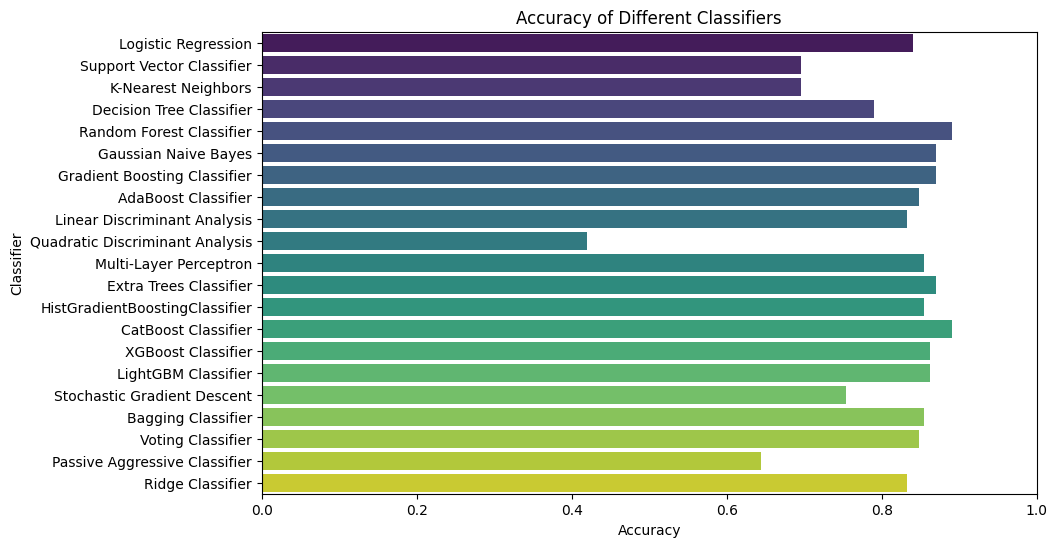

In [68]:
# Visualization of classifier accuracy
classifier_names = list(results.keys())
accuracies = [results[name]['Accuracy'] for name in classifier_names]

# Create a DataFrame for visualization
accuracy_data = pd.DataFrame({'Classifier': classifier_names, 'Accuracy': accuracies})

# Plot the accuracy using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Classifier', data=accuracy_data, palette='viridis')
plt.title('Accuracy of Different Classifiers')
plt.xlabel('Accuracy')
plt.ylabel('Classifier')
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()

In [69]:
accuracy_data = pd.DataFrame({'Classifier': classifier_names, 'Accuracy': accuracies})
accuracy_data_sorted = accuracy_data.sort_values(by='Accuracy', ascending=False)
accuracy_data_sorted.head(15)

,Classifier,Accuracy
4,Random Forest Classifier,0.891304
13,CatBoost Classifier,0.891304
5,Gaussian Naive Bayes,0.869565
6,Gradient Boosting Classifier,0.869565
11,Extra Trees Classifier,0.869565
15,LightGBM Classifier,0.862319
14,XGBoost Classifier,0.862319
10,Multi-Layer Perceptron,0.855072
12,HistGradientBoostingClassifier,0.855072
17,Bagging Classifier,0.855072


In [70]:
best_classifier_name = max(results, key=lambda name: results[name]['Accuracy'])
print(f"\nBest Classifier: {best_classifier_name}")


Best Classifier: Random Forest Classifier


### Logistic Regression

In [72]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler,RobustScaler

acc_log = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(X=df_nontree, y=y)):

    X_train, y_train = df_nontree.iloc[train_index][feature_col_nontree], y[train_index]
    X_valid, y_valid = df_nontree.iloc[val_index][feature_col_nontree], y[val_index]

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)

    print(f"Fold {fold + 1}:")
    print(classification_report(y_valid, y_pred))

    acc = roc_auc_score(y_valid, y_pred)
    acc_log.append(acc)
    print(f"ROC AUC Score for Fold {fold + 1}: {acc:.4f}")
    print("-" * 50)

print(f"\nAverage ROC AUC Score: {sum(acc_log) / len(acc_log):.4f}")

Fold 1:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        82
           1       0.91      0.88      0.90       102

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.88       184
weighted avg       0.89      0.89      0.89       184

ROC AUC Score for Fold 1: 0.8863
--------------------------------------------------
Fold 2:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        82
           1       0.90      0.87      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.87       184
weighted avg       0.88      0.88      0.88       184

ROC AUC Score for Fold 2: 0.8753
--------------------------------------------------
Fold 3:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83        82
           1       0.85      0.88      0.87  

### GaussianNB

In [56]:
from sklearn.naive_bayes import GaussianNB

acc_Gauss = []

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(X=df_nontree, y=y)):
    
    X_train = df_nontree.loc[train_index,feature_col_nontree]
    y_train = df_nontree.loc[train_index,target]
    
    X_valid = df_nontree.loc[val_index,feature_col_nontree]
    y_valid = df_nontree.loc[val_index,target]
    
    ro_scaler = MinMaxScaler()
    X_train = ro_scaler.fit_transform(X_train)
    X_valid = ro_scaler.transform(X_valid)
    
    clf = GaussianNB()
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_valid)
    
    print(f"Fold {fold + 1}:")
    print(classification_report(y_valid, y_pred,digits=4))
    
    auc = roc_auc_score(y_valid,y_pred)
    acc_Gauss.append(auc)
    print(f"ROC AUC Score for Fold {fold + 1}: {auc:.4f}")
    
    acc = accuracy_score(y_valid,y_pred)
    print(f"The accuracy for {fold+1} : {acc:.4f}")
    print("-" * 50)


print(f"\nAverage ROC AUC Score: {sum(acc_Gauss) / len(acc_Gauss):.4f}")

Fold 1:
              precision    recall  f1-score   support

           0     0.8864    0.9512    0.9176        41
           1     0.9583    0.9020    0.9293        51

    accuracy                         0.9239        92
   macro avg     0.9223    0.9266    0.9235        92
weighted avg     0.9263    0.9239    0.9241        92

ROC AUC Score for Fold 1: 0.9266
The accuracy for 1 : 0.9239
--------------------------------------------------
Fold 2:
              precision    recall  f1-score   support

           0     0.7609    0.8537    0.8046        41
           1     0.8696    0.7843    0.8247        51

    accuracy                         0.8152        92
   macro avg     0.8152    0.8190    0.8147        92
weighted avg     0.8211    0.8152    0.8158        92

ROC AUC Score for Fold 2: 0.8190
The accuracy for 2 : 0.8152
--------------------------------------------------
Fold 3:
              precision    recall  f1-score   support

           0     0.7872    0.9024    0.8409

### SUPPORT VECTOR MACHINE (SVC)

In [67]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import RobustScaler

acc_svm_grid = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# SVM için parametre aralığı belirleme
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

# GridSearchCV nesnesini oluşturma
grid_search = GridSearchCV(SVC(), param_grid, scoring='roc_auc', cv=kf, n_jobs=-1, verbose=0)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_nontree[feature_col_nontree])

grid_search.fit(X_scaled, y)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best ROC AUC Score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

for fold, (train_index, val_index) in enumerate(kf.split(X=df_nontree, y=y)):

    X_train, y_train = df_nontree.iloc[train_index][feature_col_nontree], y[train_index]
    X_valid, y_valid = df_nontree.iloc[val_index][feature_col_nontree], y[val_index]

    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_valid)

    print(f"Fold {fold + 1}:")
    print(classification_report(y_valid, y_pred))

    acc = roc_auc_score(y_valid, y_pred)
    acc_svm_grid.append(acc)
    print(f"ROC AUC Score for Fold {fold + 1}: {acc:.4f}")
    print("-" * 50)


print(f"\nAverage ROC AUC Score: {sum(acc_svm_grid) / len(acc_svm_grid):.4f}")

Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best ROC AUC Score: 0.9288
Fold 1:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91        41
           1       0.89      0.98      0.93        51

    accuracy                           0.92        92
   macro avg       0.93      0.92      0.92        92
weighted avg       0.93      0.92      0.92        92

ROC AUC Score for Fold 1: 0.9170
--------------------------------------------------
Fold 2:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        41
           1       0.92      0.88      0.90        51

    accuracy                           0.89        92
   macro avg       0.89      0.89      0.89        92
weighted avg       0.89      0.89      0.89        92

ROC AUC Score for Fold 2: 0.8924
--------------------------------------------------
Fold 3:
              precision    recall  f1-score   support

           0   

In [66]:
# Number of support vectors
num_support_vectors = len(best_model.support_)
print(f"Number of support vectors: {num_support_vectors}")

# Percentage of support vectors
percentage_support_vectors = (num_support_vectors / len(X_train)) * 100
print(f"Percentage of support vectors: {percentage_support_vectors:.2f}%")

Number of support vectors: 252
Percentage of support vectors: 34.29%


### KNeighborsClassifier

In [76]:
from sklearn.neighbors import KNeighborsClassifier

acc_KNN = []

kf = StratifiedKFold(n_splits=5)

for fold, (train_index, val_index) in enumerate(kf.split(X=df_nontree, y=y)):
    
    X_train=df_nontree.loc[train_index,feature_col_nontree]
    y_train=df_nontree.loc[train_index,target]
    
    X_valid=df_nontree.loc[val_index,feature_col_nontree]
    y_valid=df_nontree.loc[val_index,target]
    
    ro_scaler = RobustScaler()
    X_train = ro_scaler.fit_transform(X_train)
    X_valid = ro_scaler.transform(X_valid)
    
    clf = KNeighborsClassifier(n_neighbors=32)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_valid)

    print(f"Fold {fold + 1}:")
    print(classification_report(y_valid, y_pred))

    acc = roc_auc_score(y_valid, y_pred)
    acc_svm_grid.append(acc)
    print(f"ROC AUC Score for Fold {fold + 1}: {acc:.4f}")
    print("-" * 50)


print(f"\nAverage ROC AUC Score: {sum(acc_svm_grid) / len(acc_svm_grid):.4f}")

Fold 1:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82        82
           1       0.92      0.75      0.83       102

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.84      0.83      0.83       184

ROC AUC Score for Fold 1: 0.8348
--------------------------------------------------
Fold 2:
              precision    recall  f1-score   support

           0       0.95      0.88      0.91        82
           1       0.91      0.96      0.93       102

    accuracy                           0.92       184
   macro avg       0.93      0.92      0.92       184
weighted avg       0.93      0.92      0.92       184

ROC AUC Score for Fold 2: 0.9194
--------------------------------------------------
Fold 3:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79        82
           1       0.78      0.99      0.87  

## TREE BASED ALGOS

In [77]:
from sklearn.tree import DecisionTreeClassifier
acc_Dtree=[]
kf=StratifiedKFold(n_splits=5)
for fold , (trn_,val_) in enumerate(kf.split(X=df_tree,y=y)):
    
    X_train=df_tree.loc[trn_,feature_col_tree]
    y_train=df_tree.loc[trn_,target]
    
    X_valid=df_tree.loc[val_,feature_col_tree]
    y_valid=df_tree.loc[val_,target]
    
    clf=DecisionTreeClassifier(criterion="entropy")
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_valid)
    print(f"The fold is : {fold} : ")
    print(classification_report(y_valid,y_pred))
    acc=roc_auc_score(y_valid,y_pred)
    acc_Dtree.append(acc)
    print(f"The accuracy for {fold+1} : {acc}")

NameError: name 'feature_col_tree' is not defined

### Save Model

In [ ]:
import joblib
joblib.dump(logreg, 'model.pkl')

# 4. Deep Learning 

In [66]:
# Initialising the ANN
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units=16, kernel_initializer='uniform', activation='relu', input_dim=11))
# Adding dropout to prevent overfitting
classifier.add(Dropout(rate=0.1))
# Adding the second hidden layer
classifier.add(Dense(units=16, kernel_initializer='uniform', activation='relu'))
# Adding dropout to prevent overfitting
classifier.add(Dropout(rate=0.1))
# Adding the output layer
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
# Compiling the ANN
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Showing model summary of the ANN
classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Define learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9  # Decrease learning rate by 10% after each 10 epochs.

lr_scheduler = LearningRateScheduler(scheduler)

# Define early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", # metrics to monitor
    patience=20, # how many epochs to wait before stopping
    verbose=1,
    mode="max", # we need the maximum accuracy.
    restore_best_weights=True, # restore model weights from the epoch with the best value of the monitored metric
)

# Define learning rate reduction on plateau
rp = keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.2,
    patience=5,
    verbose=1,
    mode="max",
    min_lr=0.00001, # minimum learning rate
)

# Add checkpoint callback to save the best model
checkpoint = ModelCheckpoint(
    "/kaggle/working/best_model.keras", # filepath to save the model
    monitor="val_accuracy", # metric to monitor
    verbose=1, 
    save_best_only=True, # save only the model with the best val_acc
    mode="max" # looking for the maximum value of val_acc
)

# Add callbacks to the training process
callbacks = [rp, checkpoint,lr_scheduler]

In [68]:
history = classifier.fit(X_train, y_train, batch_size=32, epochs=100,
                         validation_split=0.2, callbacks=callbacks)

Epoch 1/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.5312 - loss: 0.6931
Epoch 1: val_accuracy improved from -inf to 0.49660, saving model to /kaggle/working/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5322 - loss: 0.6929 - val_accuracy: 0.4966 - val_loss: 0.6924 - learning_rate: 0.0010
Epoch 2/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4375 - loss: 0.6930
Epoch 2: val_accuracy did not improve from 0.49660
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5191 - loss: 0.6913 - val_accuracy: 0.4966 - val_loss: 0.6886 - learning_rate: 0.0010
Epoch 3/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6875 - loss: 0.6838
Epoch 3: val_accuracy improved from 0.49660 to 0.69388, saving model to /kaggle/working/best_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6135 - loss: 0.6825 - val_accuracy: 0.6939 - val_loss: 0.6758 - learning_rate: 0.0010
Epoch 4/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6

## 4.1 Hyperparameter Tuning on deep learning model

In [95]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# 1. Modeli tanımlayan fonksiyon
def build_classifier(hp):
    model = Sequential()
    
    # Hiperparametre olarak aktivasyon fonksiyonları
    activation = hp.Choice('activation', values=['relu', 'tanh', 'selu', 'elu', 'leaky_relu'])
    
    # İlk gizli katman ve giriş katmanı
    model.add(Dense(units=hp.Int('units_input', min_value=8, max_value=128, step=4),
                    kernel_initializer='uniform', activation=activation, input_dim=11))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.0, max_value=0.8, step=0.1)))
    
    # İkinci gizli katman
    model.add(Dense(units=hp.Int('units_hidden', min_value=8, max_value=128, step=4),
                    kernel_initializer='uniform', activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_hidden', min_value=0.0, max_value=0.8, step=0.1)))
    
    # Çıkış katmanı
    model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
    
    # Modelin derlenmesi (learning rate'i burada optimize ediyoruz)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate',
                                                                         min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# 2. RandomSearch Hyperparameter Tuning with `overwrite` set to True
tuner = RandomSearch(build_classifier,
                     objective='val_accuracy',
                     max_trials=20,  # Denenecek model sayısı
                     executions_per_trial=1,  # Her modeli kaç kez çalıştıracağı
                     directory='ann_tuner',  # Tuner için çalışma dizini
                     project_name='heart_disease_prediction',  # Proje adı
                     overwrite=True)  # Overwrite previous results to avoid conflicts

# 3. Adding a ModelCheckpoint callback to ensure all states are saved
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)

# 4. Hiperparametre optimizasyonunu başlatın
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, callbacks=[checkpoint_cb])

# 5. En iyi modeli seçin ve çıktıları gözlemleyin
best_model = keras.models.load_model("best_model.keras")  # Load the best saved model instead of using tuner.get_best_models()
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("En iyi modelin hiperparametreleri: ", best_hyperparameters.values)
best_model.summary()

Trial 20 Complete [00h 00m 11s]
val_accuracy: 0.864130437374115

Best val_accuracy So Far: 0.929347813129425
Total elapsed time: 00h 03m 37s
En iyi modelin hiperparametreleri:  {'activation': 'relu', 'units_input': 20, 'dropout_input': 0.0, 'units_hidden': 128, 'dropout_hidden': 0.8, 'learning_rate': 0.00224480868817636}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,333 (20.84 KB)

 Trainable params: 1,705 (6.66 KB)

 Non-trainable params: 216 (864.00 B)

 Optimizer params: 3,412 (13.33 KB)

In [97]:
best_model = keras.models.load_model("best_model.keras")  # Load the best saved model
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("En iyi modelin hiperparametreleri: ", best_hyperparameters.values)
best_model.summary()

history = best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

En iyi modelin hiperparametreleri:  {'activation': 'relu', 'units_input': 20, 'dropout_input': 0.0, 'units_hidden': 128, 'dropout_hidden': 0.8, 'learning_rate': 0.00224480868817636}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,333 (20.84 KB)

 Trainable params: 1,705 (6.66 KB)

 Non-trainable params: 216 (864.00 B)

 Optimizer params: 3,412 (13.33 KB)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8267 - loss: 0.3782 - val_accuracy: 0.8641 - val_loss: 0.3896
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8010 - loss: 0.4375 - val_accuracy: 0.8641 - val_loss: 0.3894
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8367 - loss: 0.4065 - val_accuracy: 0.8533 - val_loss: 0.3889
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8507 - loss: 0.3792 - val_accuracy: 0.8533 - val_loss: 0.3907
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8468 - loss: 0.3790 - val_accuracy: 0.8533 - val_loss: 0.3894
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8518 - loss: 0.3790 - val_accuracy: 0.8533 - val_loss: 0.3889
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8652 - loss: 0.3636 - val_accuracy: 0.8533 - val_loss: 0.3901
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8485 - loss: 0.4049 - val_accuracy: 0.8478 - val_loss

In [98]:
# En iyi hiperparametreler ile modelin yeniden eğitilmesi
best_model = Sequential()
# Giriş katmanı ve ilk gizli katman
best_model.add(Dense(units=20, kernel_initializer='uniform', activation='relu', input_dim=11))
best_model.add(BatchNormalization())  # Batch Normalization
best_model.add(Dropout(rate=0.0))  # Dropout oranı

# İkinci gizli katman
best_model.add(Dense(units=128, kernel_initializer='uniform', activation='relu'))
best_model.add(BatchNormalization())  # Batch Normalization
best_model.add(Dropout(rate=0.8))  # Dropout oranı (kullanılmıyor)

# Çıkış katmanı
best_model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))

# Modeli derleme (en iyi öğrenme oranı ile)
best_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.007893028127349816),
                   loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32,callbacks=callbacks)

# Performans değerlendirme
best_model.evaluate(X_test, y_test)

Epoch 1/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5000 - loss: 0.7790
Epoch 1: val_accuracy did not improve from 0.89130
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7149 - loss: 0.5634 - val_accuracy: 0.6033 - val_loss: 0.6588 - learning_rate: 0.0079
Epoch 2/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5271
Epoch 2: val_accuracy did not improve from 0.89130
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8294 - loss: 0.4058 - val_accuracy: 0.7446 - val_loss: 0.6381 - learning_rate: 0.0079
Epoch 3/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8438 - loss: 0.3616
Epoch 3: val_accuracy did not improve from 0.89130
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8413 - loss: 0.3953 - val_accuracy: 0.7500 - val_loss: 0.6186 - learning_rate: 0.0079
Epoch 4/100
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8750 - loss: 0.2909
Epoch 4: val_accuracy did not improve from 0.89130
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

[0.319187730550766, 0.8695651888847351]

In [100]:
# Assuming X_test and y_test are your test dataset and labels
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8679 - loss: 0.3458 
Test Loss: 0.319187730550766
Test Accuracy: 0.8695651888847351


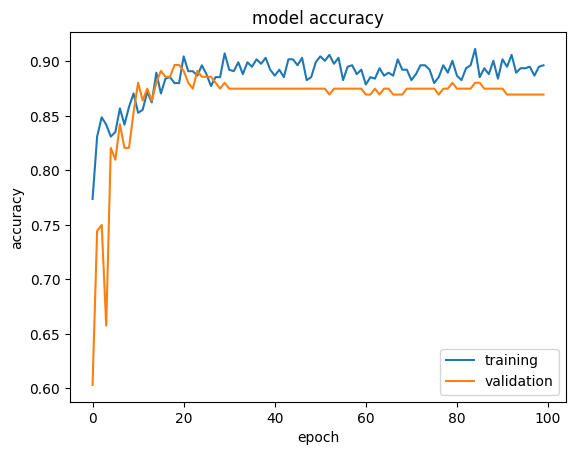

In [101]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [102]:
# Predicting the Test set results
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([[68,  9],
       [15, 92]])

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


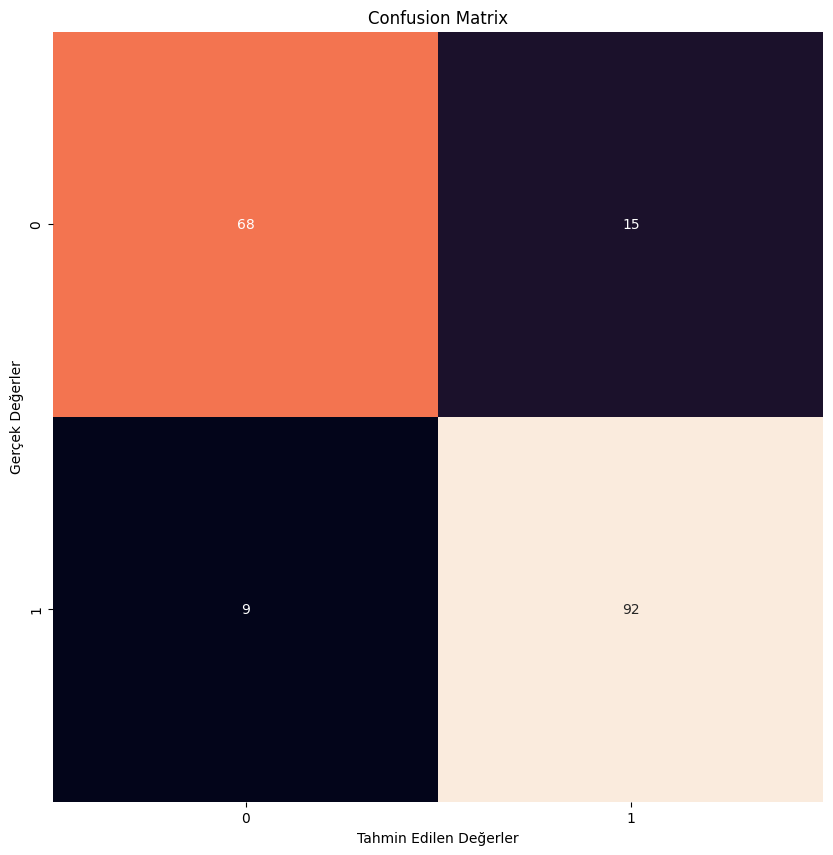

In [103]:
# Model tahminlerini al (olasılık tahmini)
y_pred_proba = best_model.predict(X_test)

# Olasılık tahminlerini sınıf tahminlerine çevir (eğer 0.5'ten büyükse 1, değilse 0 olarak sınıflandır)
y_pred = (y_pred_proba > 0.5).astype(int)

# Confusion matrix'i hesapla
mat = confusion_matrix(y_test, y_pred)

# Confusion matrix'i görselleştir
fig = plt.figure(figsize=(10, 10))  # Grafik boyutu
sns.heatmap(mat.T, square=True, annot=True, cbar=False, fmt='.0f')
plt.xlabel('Tahmin Edilen Değerler')
plt.ylabel('Gerçek Değerler')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


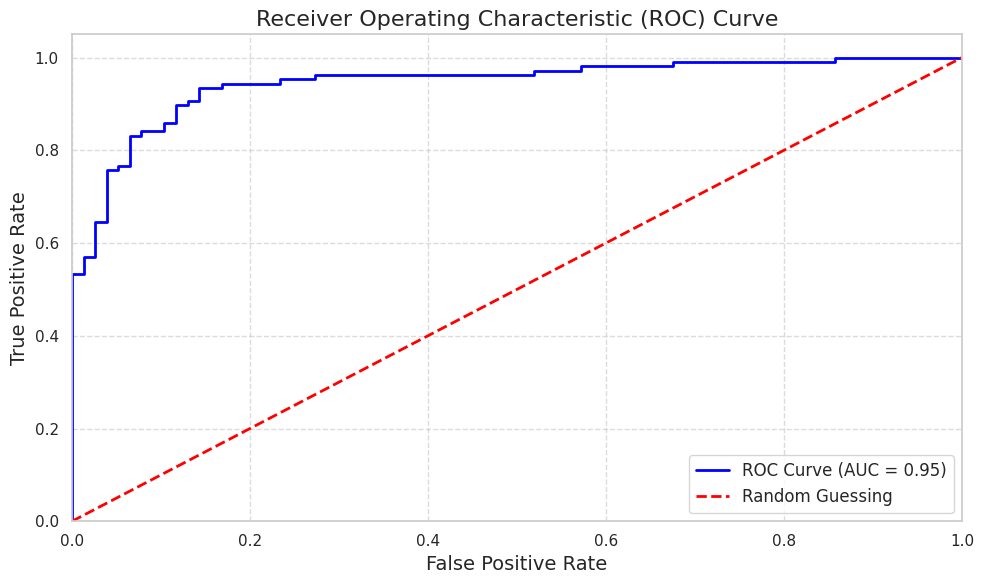

In [104]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Model tahminlerini al (olasılık tahmini)
y_pred_proba = best_model.predict(X_test)

# ROC eğrisini hesapla
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# AUC'yi hesapla
roc_auc = auc(fpr, tpr)

# ROC eğrisini çiz
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')  # Seaborn stili

plt.plot(fpr, tpr, color='blue', lw=2, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')  # Diyagonal referans çizgisi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('roc_curve_enhanced.png')
plt.show()

In [105]:
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Classification Report:
               precision    recall  f1-score   support

           0     0.8193    0.8831    0.8500        77
           1     0.9109    0.8598    0.8846       107

    accuracy                         0.8696       184
   macro avg     0.8651    0.8715    0.8673       184
weighted avg     0.8726    0.8696    0.8701       184



In [116]:
y_pred_proba = best_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)
y_pred = y_pred.flatten()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [117]:
y_pred

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1])

In [118]:
cross_checking = pd.DataFrame({'Actual' : y_test , 'Predicted' : y_pred})
cross_checking.head(10).style.background_gradient(
        cmap='coolwarm').set_properties(**{
            'font-family': 'Lucida Calligraphy',
            'color': 'LigntGreen',
            'font-size': '15px'
        })

,Actual,Predicted
668,0,0
30,1,1
377,1,1
535,1,1
807,0,0
793,1,1
363,1,1
583,0,0
165,1,0
483,1,1


<h1 style="text-align: center;font-weight: bold;">THE END</h1>

<figure>
        <img src="https://media.giphy.com/media/SfYTJuxdAbsVW/giphy.gif" alt ="Audio Art" style='width:800px;height:500px; display: block; margin-left: auto; margin-right: auto;'>
</figure>

# Referances

In [ ]:
# https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem
# https://www.kaggle.com/code/mohamedwasef/heart-disease-eda-with-ml
# https://www.kaggle.com/code/pythonafroz/heart-disease-prediction-using-11-algorithms